# Assessing metadata found in the Pangaea repository for datasets

**Aim.** The aim of this experiment is to evaluate if the RDF metadata published by [Pangaea](https://www.pangaea.de/) is following the FAIR principles guideline.

**Material and methods.** In this experiment, we launch a set of FAIR tests which are mostly based on SPARQL requests.

**Results.** We produce an UpSetPlot summarizing the number of resource validating each test, allowing to show some validation combination profiles.

In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

## 1. Retrieve a list of DOIs from the Pangaea repository API

In [3]:
TIMEOUT = (10, 300)
#NB = '10000'
NB = '10'
OUTPUT_DIR = "../results/pangaea_data/"

def pangaeaRestRequest():
    print("REST request to pangaea...")
    # rest request
    url = 'https://ws.pangaea.de/es/pangaea/panmd/_search?pretty&size=' + NB
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def pangaeaJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    for element in json_response["hits"]["hits"]:
        if "URI" in element["_source"].keys():
            doi = element["_source"]["URI"]
            dois_list.append(doi)
            
    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [4]:
response = pangaeaRestRequest()
dois_list = pangaeaJsonParser(response)

REST request to pangaea...
Parsing result...
Retrieved 10 DOIs


## 2. Selecting a subset of the DOIs to create a sample

In [5]:
import random

random.seed(42)

samples_dois_list = random.sample(dois_list, 10)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))

10


## 3. Initiating the list of metrics to be tested

In [7]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
# metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [8]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
#     metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

## 4. Launching the list of FAIR tests for each DOI

In [9]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
    
    return evals, exec_time

In [10]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_PANGAEA_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_PANGAEA_"+str(i)+".csv")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

http://schema.org/


INFO:f8d03ac0-9a71-4143-930c-69f48c8b14d5:Checking if the URL is reachable, status code: 200
INFO:f8d03ac0-9a71-4143-930c-69f48c8b14d5:Status code is OK, meaning the url is Unique.
INFO:3e834de9-8d8b-4554-b269-2b588e7e1b17:Strong evaluation:
INFO:3e834de9-8d8b-4554-b269-2b588e7e1b17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3e834de9-8d8b-4554-b269-2b588e7e1b17:Found at least one of those property in metadata
INFO:bc5b757d-14d7-436a-a699-acca2f69c83d:Checking if data is structured, looking for at least one RDF triple...
INFO:bc5b757d-14d7-436a-a699-acca2f69c83d:255 RDF triples were found, thus data is in a well structured graph format
INFO:6c058bc3-0df3-4f4c-a112-e91e7805a7d2:Checking if data is structured, looking for at least one RDF triple...
INFO:6c058bc3-0df3-4f4c-a112-e91e7805a7d2:255 RDF triples were found, thus data is in a well structured graph format
INFO:4325d933-629e-4e05-92a4-23579590bba4:Checking that at least 3 different URL

http://schema.org/


INFO:da98443a-91ac-41e0-add8-659bd6e3f646:Checking if the URL is reachable, status code: 200
INFO:da98443a-91ac-41e0-add8-659bd6e3f646:Status code is OK, meaning the url is Unique.
INFO:57930e39-f635-4ad0-945c-e6f235a2edd6:Strong evaluation:
INFO:57930e39-f635-4ad0-945c-e6f235a2edd6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57930e39-f635-4ad0-945c-e6f235a2edd6:Found at least one of those property in metadata
INFO:b9f89e38-e08c-4fd0-a070-6910e86a85c1:Checking if data is structured, looking for at least one RDF triple...
INFO:b9f89e38-e08c-4fd0-a070-6910e86a85c1:326 RDF triples were found, thus data is in a well structured graph format
INFO:a5fc8e4a-ec6d-4b06-8aae-13b4b4bd7150:Checking if data is structured, looking for at least one RDF triple...
INFO:a5fc8e4a-ec6d-4b06-8aae-13b4b4bd7150:326 RDF triples were found, thus data is in a well structured graph format
INFO:8df9aca1-7843-4eee-a540-e490173d73b1:Checking that at least 3 different URL

http://schema.org/


INFO:a06195be-b919-4e5a-abf9-ce06a066b8cd:Checking if the URL is reachable, status code: 200
INFO:a06195be-b919-4e5a-abf9-ce06a066b8cd:Status code is OK, meaning the url is Unique.
INFO:f40dea98-c17c-421b-923f-8a8807a19df7:Strong evaluation:
INFO:f40dea98-c17c-421b-923f-8a8807a19df7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f40dea98-c17c-421b-923f-8a8807a19df7:Found at least one of those property in metadata
INFO:54853607-eef6-4ff7-bca4-d3518b3c497b:Checking if data is structured, looking for at least one RDF triple...
INFO:54853607-eef6-4ff7-bca4-d3518b3c497b:234 RDF triples were found, thus data is in a well structured graph format
INFO:f4d11560-7993-46c3-abb9-7c00e7b595e2:Checking if data is structured, looking for at least one RDF triple...
INFO:f4d11560-7993-46c3-abb9-7c00e7b595e2:234 RDF triples were found, thus data is in a well structured graph format
INFO:e3bcfa0a-b6cb-4c9c-b0a0-b3e4abf3243c:Checking that at least 3 different URL

http://schema.org/


INFO:374ff2cf-c18e-4467-99d6-cf1880ac0866:Checking if the URL is reachable, status code: 200
INFO:374ff2cf-c18e-4467-99d6-cf1880ac0866:Status code is OK, meaning the url is Unique.
INFO:e254a39e-355a-45d0-afe7-00efb7c9a5f6:Strong evaluation:
INFO:e254a39e-355a-45d0-afe7-00efb7c9a5f6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e254a39e-355a-45d0-afe7-00efb7c9a5f6:Found at least one of those property in metadata
INFO:effb19ff-7107-4961-bbe6-0557fb74a30a:Checking if data is structured, looking for at least one RDF triple...
INFO:effb19ff-7107-4961-bbe6-0557fb74a30a:126 RDF triples were found, thus data is in a well structured graph format
INFO:598b9efd-9eb9-4861-9119-aeb416c34527:Checking if data is structured, looking for at least one RDF triple...
INFO:598b9efd-9eb9-4861-9119-aeb416c34527:126 RDF triples were found, thus data is in a well structured graph format
INFO:372285c9-d9f0-4e9e-a6c5-08b2b7011c1f:Checking that at least 3 different URL

http://schema.org/


INFO:95f1740c-c705-43dc-a24d-1a73ef8ab04c:Checking if the URL is reachable, status code: 200
INFO:95f1740c-c705-43dc-a24d-1a73ef8ab04c:Status code is OK, meaning the url is Unique.
INFO:1ca2f2c7-dbd2-48bc-aff4-bec2e9c71f38:Strong evaluation:
INFO:1ca2f2c7-dbd2-48bc-aff4-bec2e9c71f38:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1ca2f2c7-dbd2-48bc-aff4-bec2e9c71f38:Found at least one of those property in metadata
INFO:06cfa401-c423-442f-9a3c-362e7aee6d63:Checking if data is structured, looking for at least one RDF triple...
INFO:06cfa401-c423-442f-9a3c-362e7aee6d63:310 RDF triples were found, thus data is in a well structured graph format
INFO:2d30b7f7-ddad-4202-9400-008228aa8d81:Checking if data is structured, looking for at least one RDF triple...
INFO:2d30b7f7-ddad-4202-9400-008228aa8d81:310 RDF triples were found, thus data is in a well structured graph format
INFO:4a44dd02-3d61-4173-800b-f09da44eb8cc:Checking that at least 3 different URL

http://schema.org/


INFO:d420fa8f-8f7d-4fa5-bf6f-325103fdc236:Checking if the URL is reachable, status code: 200
INFO:d420fa8f-8f7d-4fa5-bf6f-325103fdc236:Status code is OK, meaning the url is Unique.
INFO:123bc609-cf90-4729-ada1-b6e601c61f8e:Strong evaluation:
INFO:123bc609-cf90-4729-ada1-b6e601c61f8e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:123bc609-cf90-4729-ada1-b6e601c61f8e:Found at least one of those property in metadata
INFO:a2386cf4-b6e2-434d-b239-fda8145fc9cf:Checking if data is structured, looking for at least one RDF triple...
INFO:a2386cf4-b6e2-434d-b239-fda8145fc9cf:234 RDF triples were found, thus data is in a well structured graph format
INFO:2aed98a3-63ce-4517-b103-69cf59576939:Checking if data is structured, looking for at least one RDF triple...
INFO:2aed98a3-63ce-4517-b103-69cf59576939:234 RDF triples were found, thus data is in a well structured graph format
INFO:75d4beb1-6315-4656-bf35-75f2b8868804:Checking that at least 3 different URL

http://schema.org/


INFO:383af92e-498f-4db3-a2b5-cd4fdef3e5fa:Checking if the URL is reachable, status code: 200
INFO:383af92e-498f-4db3-a2b5-cd4fdef3e5fa:Status code is OK, meaning the url is Unique.
INFO:349bf16a-0443-4a47-b5aa-ef31ddf06738:Strong evaluation:
INFO:349bf16a-0443-4a47-b5aa-ef31ddf06738:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:349bf16a-0443-4a47-b5aa-ef31ddf06738:Found at least one of those property in metadata
INFO:f74318a0-4757-4217-98c5-6a96864a82c9:Checking if data is structured, looking for at least one RDF triple...
INFO:f74318a0-4757-4217-98c5-6a96864a82c9:290 RDF triples were found, thus data is in a well structured graph format
INFO:ed4e8d72-2fdc-4f42-a69f-06709f1a163a:Checking if data is structured, looking for at least one RDF triple...
INFO:ed4e8d72-2fdc-4f42-a69f-06709f1a163a:290 RDF triples were found, thus data is in a well structured graph format
INFO:52e7f657-674e-4ec8-820b-69915485a29f:Checking that at least 3 different URL

http://schema.org/


INFO:c46f0598-5494-4966-892d-adc8d7d7d0d0:Checking if the URL is reachable, status code: 200
INFO:c46f0598-5494-4966-892d-adc8d7d7d0d0:Status code is OK, meaning the url is Unique.
INFO:6fc8fa63-5b73-4cb7-a9e6-0f5bd3e5824e:Strong evaluation:
INFO:6fc8fa63-5b73-4cb7-a9e6-0f5bd3e5824e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6fc8fa63-5b73-4cb7-a9e6-0f5bd3e5824e:Found at least one of those property in metadata
INFO:b58df54d-8795-4124-a147-97ca02166bdf:Checking if data is structured, looking for at least one RDF triple...
INFO:b58df54d-8795-4124-a147-97ca02166bdf:504 RDF triples were found, thus data is in a well structured graph format
INFO:81a249f4-01eb-44a0-82ac-d10bed98d72c:Checking if data is structured, looking for at least one RDF triple...
INFO:81a249f4-01eb-44a0-82ac-d10bed98d72c:504 RDF triples were found, thus data is in a well structured graph format
INFO:7fd80b6a-a4cd-4254-8510-3ab3b080bb27:Checking that at least 3 different URL

http://schema.org/


INFO:4e1a9917-a444-4fbf-b676-3d94b35605fd:Checking if the URL is reachable, status code: 200
INFO:4e1a9917-a444-4fbf-b676-3d94b35605fd:Status code is OK, meaning the url is Unique.
INFO:cc85e456-312b-4045-b104-8100b0630b0f:Strong evaluation:
INFO:cc85e456-312b-4045-b104-8100b0630b0f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc85e456-312b-4045-b104-8100b0630b0f:Found at least one of those property in metadata
INFO:517cecc1-24de-448e-a6b7-379f2cde7cb2:Checking if data is structured, looking for at least one RDF triple...
INFO:517cecc1-24de-448e-a6b7-379f2cde7cb2:155 RDF triples were found, thus data is in a well structured graph format
INFO:4bdced7b-12e3-4cbe-afdd-15a4a12c5d38:Checking if data is structured, looking for at least one RDF triple...
INFO:4bdced7b-12e3-4cbe-afdd-15a4a12c5d38:155 RDF triples were found, thus data is in a well structured graph format
INFO:13979895-df7a-4824-9f40-9a00c80eb665:Checking that at least 3 different URL

http://schema.org/


In [11]:
len(df)

10

In [12]:
df_time

,ID,F1A,F1B,F2A,I1,I3,R1.1,R1.2
0,https://doi.org/10.1594/PANGAEA.131313,0.0,0.01,0.0,0.0,0.01,0.01,0.01
1,https://doi.org/10.1594/PANGAEA.52268,0.0,0.01,0.0,0.0,0.00,0.01,0.02
2,https://doi.org/10.1594/PANGAEA.695985,0.0,0.01,0.0,0.0,0.00,0.01,0.01
3,https://doi.org/10.1594/PANGAEA.377746,0.0,0.01,0.0,0.0,0.00,0.01,0.01
4,https://doi.org/10.1594/PANGAEA.781744,0.0,0.01,0.0,0.0,0.00,0.01,0.01
5,https://doi.org/10.1594/PANGAEA.108393,0.0,0.01,0.0,0.0,0.00,0.01,0.02
6,https://doi.org/10.1594/PANGAEA.381868,0.0,0.01,0.0,0.0,0.00,0.01,0.01
7,https://doi.org/10.1594/PANGAEA.837994,0.0,0.01,0.0,0.0,0.00,0.01,0.01
8,https://doi.org/10.1594/PANGAEA.110694,0.0,0.01,0.0,0.0,0.00,0.01,0.01
9,https://doi.org/10.1594/PANGAEA.95128,0.0,0.01,0.0,0.0,0.00,0.01,0.01


In [13]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_PANGAEA_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

## 5. Generating the UpSetPlot

In [15]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
                          'I1': I1, 
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
df_upset

id
F1B  F2A  I1   I3   R11  R12                                          
True True True True True False  https://doi.org/10.1594/PANGAEA.382060
                         False  https://doi.org/10.1594/PANGAEA.398955
                         False  https://doi.org/10.1594/PANGAEA.694450
                         False   https://doi.org/10.1594/PANGAEA.87285
                         False  https://doi.org/10.1594/PANGAEA.265606
...                                                                ...
                         False  https://doi.org/10.1594/PANGAEA.360017
                         False  https://doi.org/10.1594/PANGAEA.883992
                         False  https://doi.org/10.1594/PANGAEA.748756
                         False  https://doi.org/10.1594/PANGAEA.774371
                         False  https://doi.org/10.1594/PANGAEA.792562

[410 rows x 1 columns]

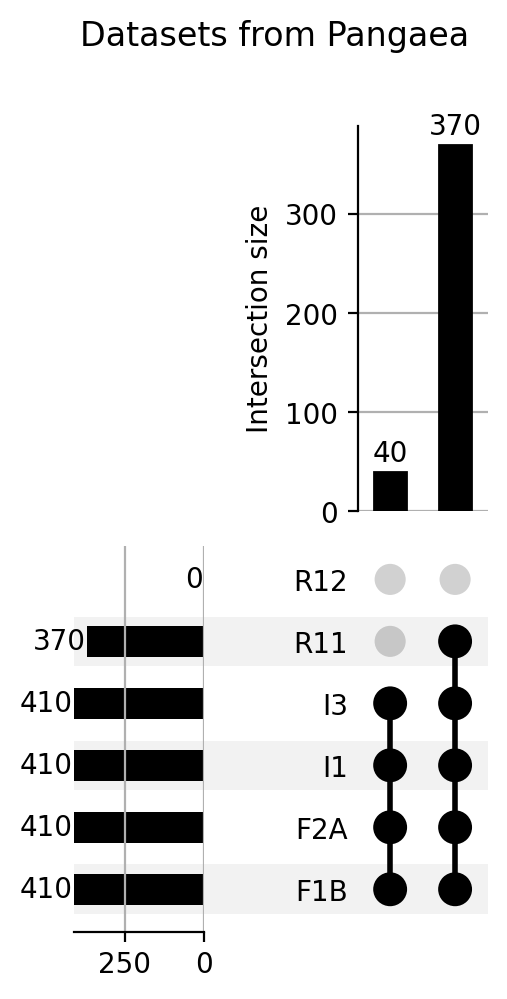

In [16]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Pangaea")
plt.savefig(OUTPUT_DIR + 'pangaea-no-F2B-no-R13.png', format="png")
plt.show()